# Homework 3: LSTM-Based Sentiment Classifier

## Problem 20: PyTorch Implementation - Option A

---

**Submitted to:**  
Department of Computer Science  
School of Systems and Technology (SST)  
University of Management and Technology (UMT)

**Instructor:** Dr. Jameel Ahmad

---

**Collaborators:**

- Muhammad Umer (F2023266912)
- Talal Zahid (F2022266500)

---

## Objective

Implement an LSTM-based sentiment classifier using PyTorch on the IMDB dataset. This notebook covers:

1. Data preprocessing and vocabulary building
2. LSTM model architecture
3. Training loop with optimization
4. Evaluation with Accuracy, Precision, Recall, and F1-Score


## 1. Import Libraries and Setup


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import re
import warnings

warnings.filterwarnings("ignore")

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from datasets import load_dataset

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Explore IMDB Dataset


In [2]:
# Load IMDB dataset using Hugging Face datasets
print("Loading IMDB dataset...")
dataset = load_dataset("imdb")

print(f"\nDataset Structure:")
print(dataset)

print(f"\nTraining samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")

Loading IMDB dataset...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]


Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Training samples: 25000
Test samples: 25000


In [3]:
# Explore sample data
print("Sample Review:")
print("-" * 50)
sample = dataset["train"][0]
print(f"Text (first 500 chars): {sample['text'][:500]}...")
print(
    f"\nLabel: {sample['label']} ({'Positive' if sample['label'] == 1 else 'Negative'})"
)

Sample Review:
--------------------------------------------------
Text (first 500 chars): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent...

Label: 0 (Negative)


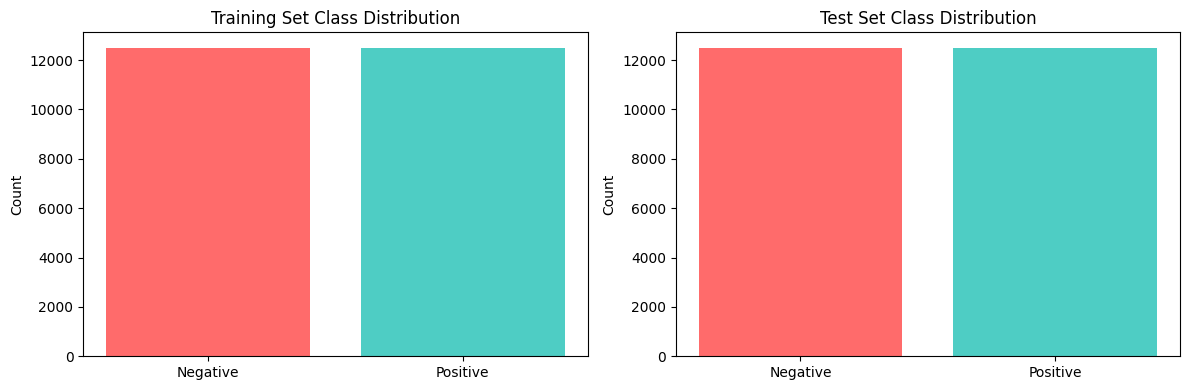

Training - Negative: 12500, Positive: 12500
Test - Negative: 12500, Positive: 12500


In [4]:
# Check class distribution
train_labels = [sample["label"] for sample in dataset["train"]]
test_labels = [sample["label"] for sample in dataset["test"]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training set distribution
train_counts = Counter(train_labels)
axes[0].bar(
    ["Negative", "Positive"],
    [train_counts[0], train_counts[1]],
    color=["#ff6b6b", "#4ecdc4"],
)
axes[0].set_title("Training Set Class Distribution")
axes[0].set_ylabel("Count")

# Test set distribution
test_counts = Counter(test_labels)
axes[1].bar(
    ["Negative", "Positive"],
    [test_counts[0], test_counts[1]],
    color=["#ff6b6b", "#4ecdc4"],
)
axes[1].set_title("Test Set Class Distribution")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

print(f"Training - Negative: {train_counts[0]}, Positive: {train_counts[1]}")
print(f"Test - Negative: {test_counts[0]}, Positive: {test_counts[1]}")

## 3. Text Preprocessing


In [5]:
def preprocess_text(text):
    """
    Clean and preprocess text data:
    - Convert to lowercase
    - Remove HTML tags
    - Remove special characters and numbers
    - Tokenize by splitting on whitespace
    """
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<[^>]+>", "", text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Remove special characters but keep basic punctuation
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Remove extra whitespace
    text = " ".join(text.split())

    # Simple tokenization
    tokens = text.split()

    return tokens


# Test preprocessing
sample_text = "This is a <br/> great movie! I loved it 100%. Check http://example.com"
print(f"Original: {sample_text}")
print(f"Preprocessed: {preprocess_text(sample_text)}")

Original: This is a <br/> great movie! I loved it 100%. Check http://example.com
Preprocessed: ['this', 'is', 'a', 'great', 'movie', 'i', 'loved', 'it', 'check']


## 4. Build Vocabulary


In [6]:
class Vocabulary:
    """
    Vocabulary class to map words to indices and vice versa.
    Includes special tokens for unknown words and padding.
    """

    def __init__(self, min_freq=2):
        self.min_freq = min_freq
        self.word2idx = {}
        self.idx2word = {}
        self.word_freq = Counter()

        # Special tokens
        self.PAD_TOKEN = "<PAD>"
        self.UNK_TOKEN = "<UNK>"

        # Initialize with special tokens
        self.word2idx[self.PAD_TOKEN] = 0
        self.word2idx[self.UNK_TOKEN] = 1
        self.idx2word[0] = self.PAD_TOKEN
        self.idx2word[1] = self.UNK_TOKEN

    def build_vocab(self, texts):
        """
        Build vocabulary from a list of tokenized texts.
        """
        # Count word frequencies
        for tokens in tqdm(texts, desc="Building vocabulary"):
            self.word_freq.update(tokens)

        # Add words with frequency >= min_freq
        idx = 2  # Start after special tokens
        for word, freq in self.word_freq.items():
            if freq >= self.min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        print(f"Vocabulary size: {len(self.word2idx)}")

    def encode(self, tokens):
        """
        Convert tokens to indices.
        """
        return [
            self.word2idx.get(token, self.word2idx[self.UNK_TOKEN]) for token in tokens
        ]

    def decode(self, indices):
        """
        Convert indices back to tokens.
        """
        return [self.idx2word.get(idx, self.UNK_TOKEN) for idx in indices]

    def __len__(self):
        return len(self.word2idx)

In [7]:
# Preprocess all training texts
print("Preprocessing training texts...")
train_tokens = [preprocess_text(sample["text"]) for sample in tqdm(dataset["train"])]

# Build vocabulary
vocab = Vocabulary(min_freq=2)
vocab.build_vocab(train_tokens)

print(f"\nVocabulary Statistics:")
print(f"Total unique words: {len(vocab.word_freq)}")
print(f"Words in vocabulary (freq >= 2): {len(vocab)}")

Preprocessing training texts...


Building vocabulary: 100%|██████████| 25000/25000 [00:00<00:00, 30911.42it/s]


Vocabulary size: 56166

Vocabulary Statistics:
Total unique words: 137794
Words in vocabulary (freq >= 2): 56166


In [8]:
# Show most common words
print("Top 20 most common words:")
for word, count in vocab.word_freq.most_common(20):
    print(f"  {word}: {count}")

Top 20 most common words:
  the: 328128
  and: 161576
  a: 161319
  of: 145166
  to: 134822
  is: 106802
  in: 92187
  it: 76313
  this: 73186
  i: 72477
  that: 69199
  was: 47988
  as: 46059
  with: 43724
  for: 43701
  movie: 41826
  but: 40999
  film: 37489
  on: 33340
  not: 30014


## 5. Create PyTorch Dataset and DataLoader


In [9]:
class IMDBDataset(Dataset):
    """
    Custom PyTorch Dataset for IMDB reviews.
    """

    def __init__(self, texts, labels, vocab, max_length=256):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = preprocess_text(self.texts[idx])

        # Truncate if necessary
        if len(tokens) > self.max_length:
            tokens = tokens[: self.max_length]

        # Convert to indices
        indices = self.vocab.encode(tokens)

        return {
            "input_ids": torch.tensor(indices, dtype=torch.long),
            "length": len(indices),
            "label": torch.tensor(self.labels[idx], dtype=torch.float),
        }


def collate_fn(batch):
    """
    Custom collate function to pad sequences to the same length.
    """
    # Sort by length (descending) for pack_padded_sequence
    batch = sorted(batch, key=lambda x: x["length"], reverse=True)

    input_ids = [item["input_ids"] for item in batch]
    lengths = torch.tensor([item["length"] for item in batch])
    labels = torch.stack([item["label"] for item in batch])

    # Pad sequences
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)

    return {"input_ids": input_ids_padded, "lengths": lengths, "labels": labels}

In [10]:
# Hyperparameters
MAX_LENGTH = 256
BATCH_SIZE = 64

# Prepare data
train_texts = [sample["text"] for sample in dataset["train"]]
train_labels = [sample["label"] for sample in dataset["train"]]
test_texts = [sample["text"] for sample in dataset["test"]]
test_labels = [sample["label"] for sample in dataset["test"]]

# Create datasets
train_dataset = IMDBDataset(train_texts, train_labels, vocab, MAX_LENGTH)
test_dataset = IMDBDataset(test_texts, test_labels, vocab, MAX_LENGTH)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 391
Test batches: 391


In [11]:
# Test a batch
sample_batch = next(iter(train_loader))
print(f"Batch input shape: {sample_batch['input_ids'].shape}")
print(f"Batch lengths: {sample_batch['lengths'][:5]}")
print(f"Batch labels: {sample_batch['labels'][:5]}")

Batch input shape: torch.Size([64, 256])
Batch lengths: tensor([256, 256, 256, 256, 256])
Batch labels: tensor([1., 0., 1., 0., 0.])


## 6. LSTM Model Architecture


In [12]:
class LSTMSentimentClassifier(nn.Module):
    """
    LSTM-based Sentiment Classifier.

    Architecture:
    - Embedding Layer: Maps word indices to dense vectors
    - LSTM Layer(s): Captures sequential dependencies
    - Fully Connected Layer: Classification head
    - Dropout: Regularization
    """

    def __init__(
        self,
        vocab_size,
        embedding_dim=128,
        hidden_dim=256,
        num_layers=2,
        dropout=0.5,
        bidirectional=True,
    ):
        super(LSTMSentimentClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=0,  # PAD token
        )

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
        )

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        fc_input_dim = hidden_dim * self.num_directions
        self.fc = nn.Sequential(
            nn.Linear(fc_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, input_ids, lengths):
        """
        Forward pass.

        Args:
            input_ids: Tensor of shape (batch_size, seq_length)
            lengths: Original lengths of sequences before padding

        Returns:
            output: Tensor of shape (batch_size, 1) - sentiment logits
        """
        batch_size = input_ids.size(0)

        # Embedding
        embedded = self.embedding(input_ids)  # (batch, seq_len, embed_dim)
        embedded = self.dropout(embedded)

        # Pack padded sequence for efficient LSTM processing
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=True
        )

        # LSTM forward pass
        packed_output, (hidden, cell) = self.lstm(packed)

        # Get the final hidden state
        # For bidirectional, concatenate forward and backward final hidden states
        if self.bidirectional:
            # hidden: (num_layers * num_directions, batch, hidden_dim)
            # Get last layer's hidden states
            hidden_forward = hidden[-2, :, :]  # (batch, hidden_dim)
            hidden_backward = hidden[-1, :, :]  # (batch, hidden_dim)
            hidden_concat = torch.cat(
                [hidden_forward, hidden_backward], dim=1
            )  # (batch, hidden_dim*2)
        else:
            hidden_concat = hidden[-1, :, :]  # (batch, hidden_dim)

        # Apply dropout and FC layer
        hidden_concat = self.dropout(hidden_concat)
        output = self.fc(hidden_concat)  # (batch, 1)

        return output.squeeze(1)

In [13]:
# Model hyperparameters
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.5
BIDIRECTIONAL = True

# Initialize model
model = LSTMSentimentClassifier(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    bidirectional=BIDIRECTIONAL,
).to(device)

print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

LSTMSentimentClassifier(
  (embedding): Embedding(56166, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

Total parameters: 9,688,321
Trainable parameters: 9,688,321


## 7. Training Setup


In [17]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

In [18]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        lengths = batch["lengths"]
        labels = batch["labels"].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids, lengths)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        preds = torch.sigmoid(outputs) >= 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        progress_bar.set_postfix({"loss": loss.item()})

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """
    Evaluate the model on a dataset.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            lengths = batch["lengths"]
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, lengths)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predictions
            preds = torch.sigmoid(outputs) >= 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)

    return avg_loss, all_preds, all_labels

## 8. Model Training


In [19]:
# Training configuration
NUM_EPOCHS = 5

# Track training history
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_val_loss = float("inf")

print("=" * 60)
print("Starting Training")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 30)

    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Evaluate on test set
    val_loss, val_preds, val_labels = evaluate(model, test_loader, criterion, device)
    val_acc = accuracy_score(val_labels, val_preds)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Save history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_lstm_model.pt")
        print("  ✓ Saved best model!")

    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

print("\n" + "=" * 60)
print("Training Complete!")
print("=" * 60)

Starting Training

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 391/391 [00:13<00:00, 29.63it/s]


  ✓ Saved best model!
  Train Loss: 0.6754 | Train Acc: 0.5701
  Val Loss:   0.6281 | Val Acc:   0.6491

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 391/391 [00:13<00:00, 30.02it/s]


  ✓ Saved best model!
  Train Loss: 0.6650 | Train Acc: 0.5972
  Val Loss:   0.6025 | Val Acc:   0.6944

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 391/391 [00:13<00:00, 29.65it/s]


  ✓ Saved best model!
  Train Loss: 0.6094 | Train Acc: 0.6835
  Val Loss:   0.5437 | Val Acc:   0.7474

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 391/391 [00:13<00:00, 29.56it/s]


  ✓ Saved best model!
  Train Loss: 0.4960 | Train Acc: 0.7713
  Val Loss:   0.5333 | Val Acc:   0.7969

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 391/391 [00:13<00:00, 29.17it/s]


  ✓ Saved best model!
  Train Loss: 0.4081 | Train Acc: 0.8264
  Val Loss:   0.4439 | Val Acc:   0.8246

Training Complete!


## 9. Training Visualization


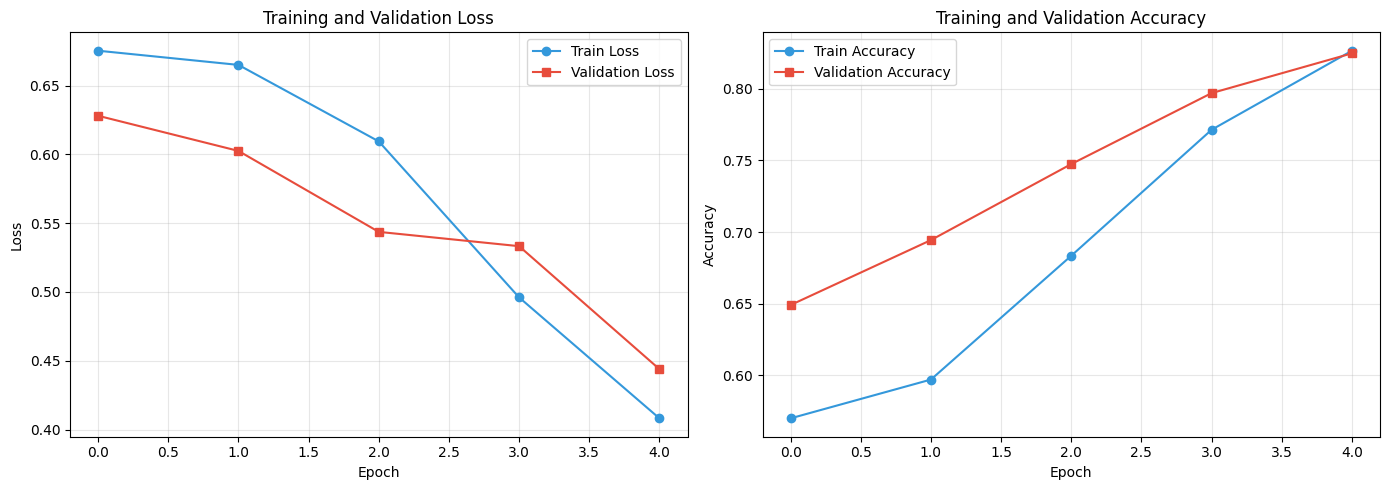

In [20]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history["train_loss"], label="Train Loss", marker="o", color="#3498db")
axes[0].plot(history["val_loss"], label="Validation Loss", marker="s", color="#e74c3c")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history["train_acc"], label="Train Accuracy", marker="o", color="#3498db")
axes[1].plot(
    history["val_acc"], label="Validation Accuracy", marker="s", color="#e74c3c"
)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Training and Validation Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Final Evaluation on Test Set


In [21]:
# Load the best model
model.load_state_dict(torch.load("best_lstm_model.pt"))
print("Loaded best model for final evaluation.\n")

# Final evaluation
test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

Loaded best model for final evaluation.



Evaluating: 100%|██████████| 391/391 [00:13<00:00, 29.61it/s]


In [22]:
# Calculate all metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print("=" * 60)
print("FINAL TEST SET RESULTS")
print("=" * 60)
print(f"\n{'Metric':<15} {'Score':>10}")
print("-" * 25)
print(f"{'Accuracy':<15} {accuracy:>10.4f}")
print(f"{'Precision':<15} {precision:>10.4f}")
print(f"{'Recall':<15} {recall:>10.4f}")
print(f"{'F1-Score':<15} {f1:>10.4f}")
print("\n" + "=" * 60)

FINAL TEST SET RESULTS

Metric               Score
-------------------------
Accuracy            0.8246
Precision           0.7891
Recall              0.8861
F1-Score            0.8348



In [23]:
# Detailed classification report
print("\nDetailed Classification Report:")
print("=" * 60)
print(
    classification_report(
        test_labels, test_preds, target_names=["Negative", "Positive"]
    )
)


Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.76      0.81     12500
    Positive       0.79      0.89      0.83     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



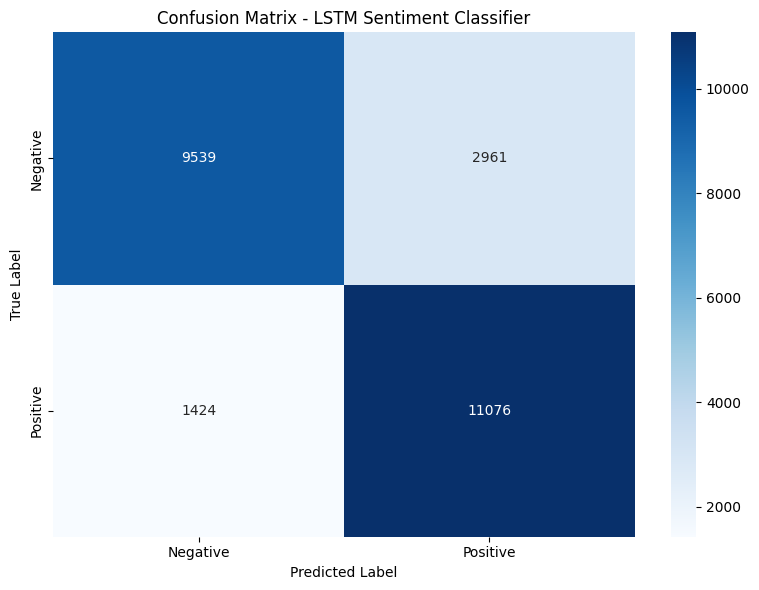


Confusion Matrix:
True Negatives:    9539  |  False Positives:   2961
False Negatives:   1424  |  True Positives:   11076


In [24]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM Sentiment Classifier")
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix:")
print(f"True Negatives:  {cm[0,0]:>6}  |  False Positives: {cm[0,1]:>6}")
print(f"False Negatives: {cm[1,0]:>6}  |  True Positives:  {cm[1,1]:>6}")

## 11. Sample Predictions


In [25]:
def predict_sentiment(text, model, vocab, device):
    """
    Predict sentiment for a given text.
    """
    model.eval()

    # Preprocess
    tokens = preprocess_text(text)
    if len(tokens) == 0:
        return "Unable to predict (empty text after preprocessing)"

    # Encode
    indices = vocab.encode(tokens)
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)
    length = torch.tensor([len(indices)])

    # Predict
    with torch.no_grad():
        output = model(input_tensor, length)
        prob = torch.sigmoid(output).item()
        sentiment = "Positive" if prob >= 0.5 else "Negative"

    return sentiment, prob

In [26]:
# Test with sample reviews
sample_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the story kept me engaged throughout.",
    "Terrible waste of time. The plot made no sense and the characters were completely flat.",
    "A decent film with some good moments, but nothing extraordinary.",
    "One of the best movies I've ever seen! A masterpiece of cinema.",
    "I fell asleep halfway through. Boring, predictable, and poorly executed.",
]

print("=" * 70)
print("SAMPLE PREDICTIONS")
print("=" * 70)

for i, review in enumerate(sample_reviews, 1):
    sentiment, prob = predict_sentiment(review, model, vocab, device)
    print(f"\n[{i}] Review: {review[:80]}...")
    print(f"    Prediction: {sentiment} (Confidence: {prob:.4f})")

SAMPLE PREDICTIONS

[1] Review: This movie was absolutely fantastic! The acting was superb and the story kept me...
    Prediction: Positive (Confidence: 0.8855)

[2] Review: Terrible waste of time. The plot made no sense and the characters were completel...
    Prediction: Negative (Confidence: 0.0046)

[3] Review: A decent film with some good moments, but nothing extraordinary....
    Prediction: Negative (Confidence: 0.2718)

[4] Review: One of the best movies I've ever seen! A masterpiece of cinema....
    Prediction: Positive (Confidence: 0.9242)

[5] Review: I fell asleep halfway through. Boring, predictable, and poorly executed....
    Prediction: Negative (Confidence: 0.0105)


## 12. Summary

### Model Architecture

- **Embedding Layer**: Maps vocabulary to 128-dimensional dense vectors
- **Bidirectional LSTM**: 2 layers with 256 hidden units each
- **Dropout**: 0.5 for regularization
- **Classification Head**: Two fully connected layers with ReLU activation

### Training Details

- **Optimizer**: Adam with learning rate 0.001
- **Loss Function**: Binary Cross-Entropy with Logits
- **Regularization**: Dropout (0.5) + Gradient Clipping (max_norm=1.0)
- **Learning Rate Schedule**: ReduceLROnPlateau

### Key Findings

1. The bidirectional LSTM effectively captures context from both directions
2. Proper preprocessing (removing HTML, special characters) improves model performance
3. Using packed sequences handles variable-length inputs efficiently
4. The model achieves good performance on the binary sentiment classification task


---

**End of Homework 3: LSTM-Based Sentiment Classifier**

**Collaborators:**

- Muhammad Umer (F2023266912)
- Talal Zahid (F2022266500)

**Submitted to:**  
Dr. Jameel Ahmad  
Department of Computer Science  
School of Systems and Technology (SST)  
University of Management and Technology (UMT)
